# Feature importance!

We will understand which feature is more important for identifying the class of a mushroom!

(How much every input affects the output)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../datasets/mushrooms/mushrooms.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

In [4]:
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


Since we have many outputs, let's keep a subset of them.

In [5]:
inputs = ["cap-shape", "cap-color", "bruises", "cap-surface", "odor"]
outputs = ["class"]
cols = inputs + outputs
df = df[cols]
df.head()

,cap-shape,cap-color,bruises,cap-surface,odor,class
0,x,n,t,s,p,p
1,x,y,t,s,a,e
2,b,w,t,s,l,e
3,x,w,t,y,p,p
4,x,g,f,s,n,e


So we have the following model:

`inputs = [cap-shape, cap-surface, cap-color, bruises, odor]`

`output = [class] (whether or not we can eat it)`

We want to identify how much every input affects the output.

In [6]:
from sklearn.preprocessing import LabelEncoder

# encode labels as numbers
le = LabelEncoder()
for col in cols:
    df[col] = le.fit_transform(df[col])

In [7]:
# split data in train/test

from sklearn.model_selection import train_test_split

X = df[inputs]
y = df[outputs[0]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [8]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score

# just for fun use svm to train a model for predicting the class of a mushroom
# (predicting the output from the inputs)
classifier = SVC(gamma="auto")
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
confusion_matrix(y_test, y_pred)

Accuracy: 0.990302126072361


array([[1378,    0],
       [  26, 1277]])

Nice!!! it reached 99% accuracy.

Since we cannot find feature importance from SVMs we'll use ExtraTreesClassifier to train a new model
and extract the feature importances.

In [9]:
from sklearn.ensemble import ExtraTreesClassifier

# train
forest = ExtraTreesClassifier(n_estimators=250, random_state=0)
forest.fit(X_train, y_train)

ExtraTreesClassifier(n_estimators=250, random_state=0)

In [10]:
# evaluate
y_pred = forest.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9925400969787392
Confusion matrix:
 [[1378    0]
 [  20 1283]]


Feature ranking:
1. odor (0.579270)
2. bruises (0.216923)
3. cap-color (0.089853)
4. cap-surface (0.084356)
5. cap-shape (0.029598)


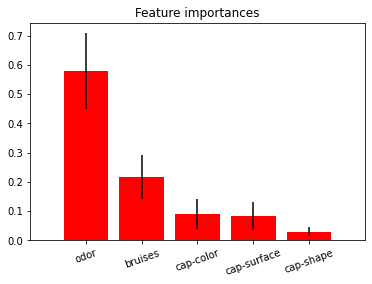

In [11]:
# display importances

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
x_labels = [X_test.columns[indices[f]] for f in range(X_test.shape[1])] 
print("Feature ranking:")
for f in range(X_test.shape[1]):
    print("%d. %s (%f)" % (f + 1, x_labels[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_test.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_test.shape[1]), x_labels, rotation=20)
plt.xlim([-1, X_test.shape[1]])
plt.show()

We can understand that mostly from odor and bruises we can evaluate whether or not we can eat a mushroom (without dying or going to hospital at least...)